In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [36]:
import tensorflow as tf

In [37]:
from agnfinder.tf_sampling import deep_emulator

In [38]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [39]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling', 'agn_inclination']
# save_dir = 'results/emulated_sampling/real'
save_dir = '/media/mike/beta/agnfinder_results/uk_ir_selection_577_inc_med'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert galaxy_locs

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        f = h5py.File(galaxy_loc, mode='r')
#         print(f['is_accepted'][...].mean())
        if f['is_accepted'][...].mean() < 0.6:
            print(f['is_accepted'])
        else:
            galaxies.append({
                'samples': np.squeeze(f['samples'][::100]),
                'name': galaxy_loc.split('_')[-2],
                'true_observations': np.squeeze(f['true_observations'][...]),
                'redshift': f['redshift'][...],
                'uncertainty': f['uncertainty'][...]
            })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [40]:
galaxies[0]['true_observations'].shape

(12,)

### Load parquet for labels

In [41]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
labels = pd.read_parquet('data/uk_ir_selection_577.parquet')

In [42]:
# labels.columns.values

In [43]:
labels['most_likely_rf_class'] = labels[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)
labels['most_likely_rf_class'].value_counts()

starforming    150
passive        150
qso            150
agn            107
starburst       20
Name: most_likely_rf_class, dtype: int64

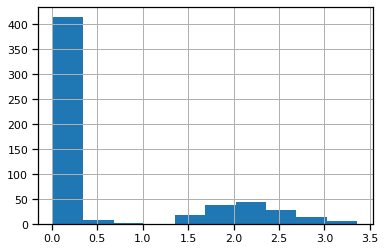

In [44]:
labels['redshift'].hist()

In [45]:
label_dict = dict(zip(labels.index, labels['most_likely_rf_class'].values))
# label_dict

In [46]:
for galaxy in galaxies:
    galaxy['rf_class'] = label_dict[int(galaxy['name'])]

In [47]:
# galaxy_locs

### How do we do at reproducing observations?

In [48]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

In [49]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])



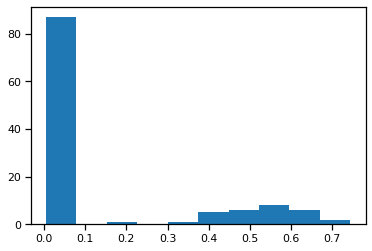

In [50]:
redshifts = np.array([g['redshift'] for g in galaxies]).squeeze()
_ = plt.hist(redshifts)

In [51]:
redshifts.shape

(116,)

In [52]:
import corner

In [53]:
galaxy['samples'].shape

(800, 8)

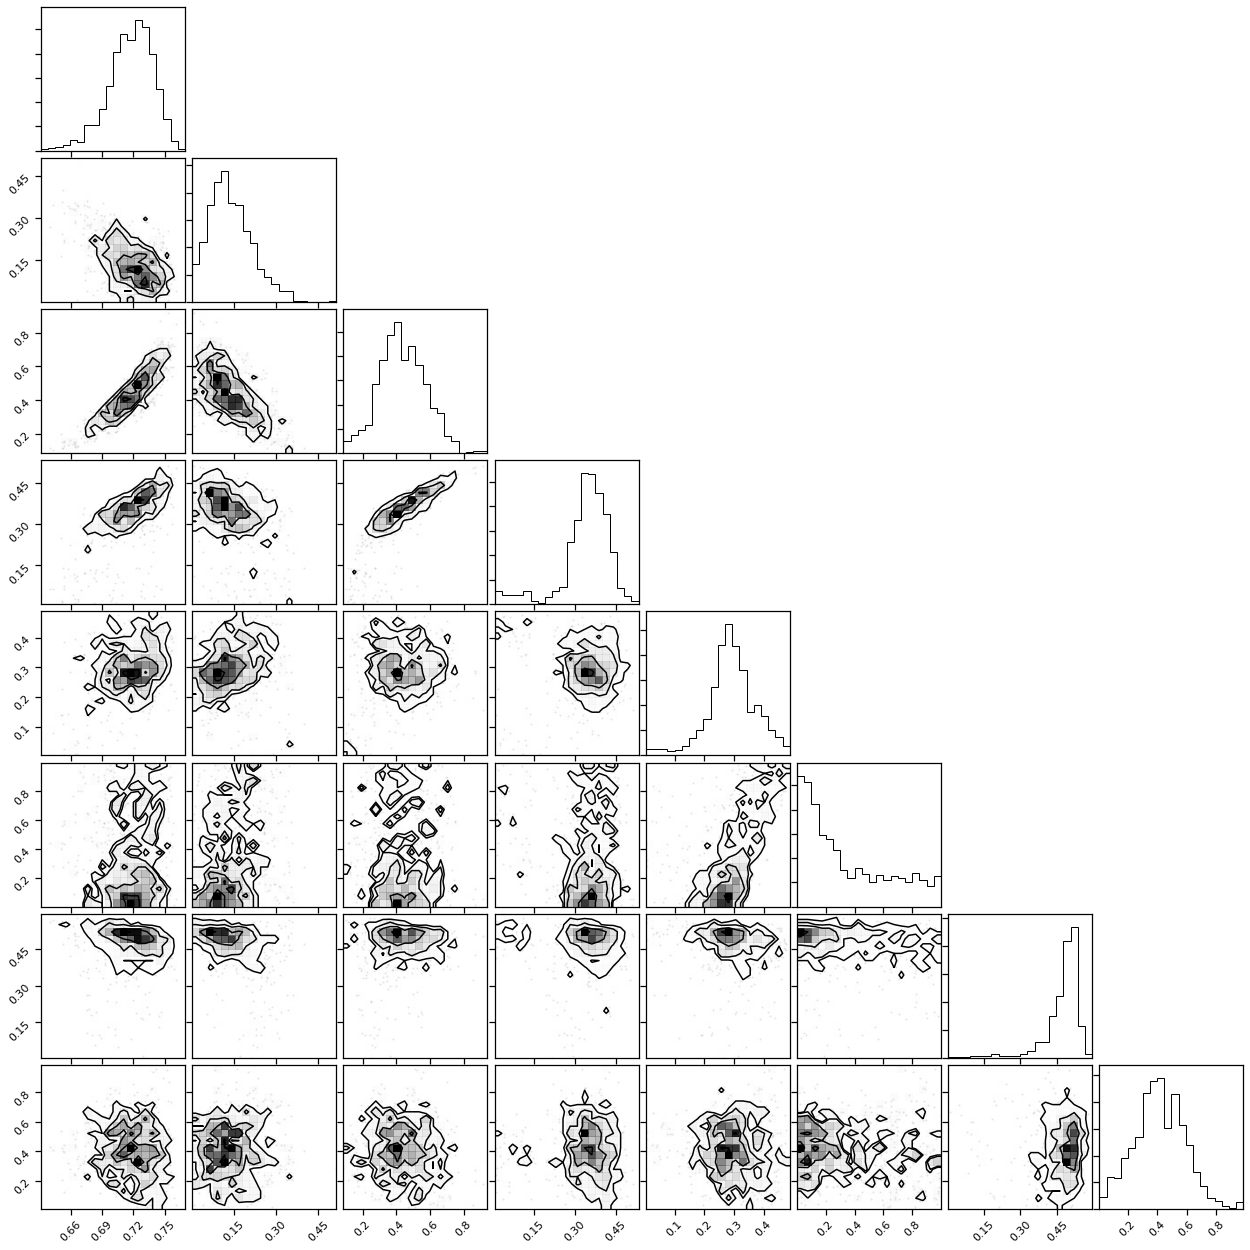

In [54]:
_ = corner.corner(galaxy['samples'])

In [55]:
# theta = np.ones((1, 8)) * 0.5
# for z in np.linspace(0, .9, 10):
#     theta[:, 0] = z
#     plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+', label=z)
# plt.legend()

In [56]:
# theta = np.ones((1, 8)) * 0.5
# for z in np.linspace(0, .9, 10):
#     theta[:, 1] = z
#     plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



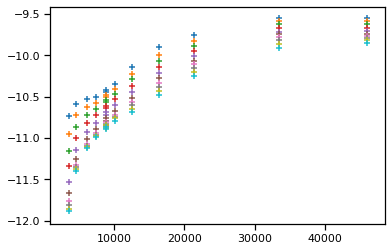

In [57]:
theta = np.ones((1, 9)) * 0.5
for z in np.linspace(0, .9, 10):
    theta[:, 2] = z
    plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

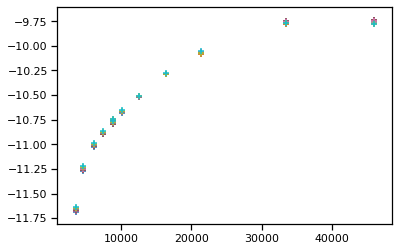

In [58]:
theta = np.ones((1, 9)) * 0.5
for z in np.linspace(0, .9, 10):
    theta[:, -1] = z
    plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

In [59]:
list(zip(np.log10(galaxy['true_observations']), np.log10(galaxy['uncertainty'] / 5.)))

[(-7.778141, -9.141617),
 (-7.0569577, -9.278109),
 (-6.73202, -9.074944),
 (-6.5466084, -8.906845),
 (-6.4082923, -8.394046),
 (-6.1787624, -8.248589),
 (-6.2918277, -8.315001),
 (-6.1640153, -8.162403),
 (-6.3839574, -8.444721),
 (-6.4973063, -8.697152),
 (-6.406193, -8.063408),
 (-6.47028, -8.060549)]

In [60]:
def plot_galaxy(galaxy, ax, emulator, wavelengths):
    true_photometry = galaxy['true_observations']
    redshifts = np.array([galaxy['redshift'] for _ in range(len(galaxy['samples']))])
#     print(redshifts.shape)
#     print(galaxy['samples'].shape)
    params_with_redshift = np.concatenate((redshifts, galaxy['samples']), axis=1)
#     print(params_with_redshift.shape)
    sample_photometry = deep_emulator.denormalise_photometry(emulator(params_with_redshift)).numpy()
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry[:500]:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.02)
    ax.legend()
    ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [61]:
galaxy['rf_class']

'agn'

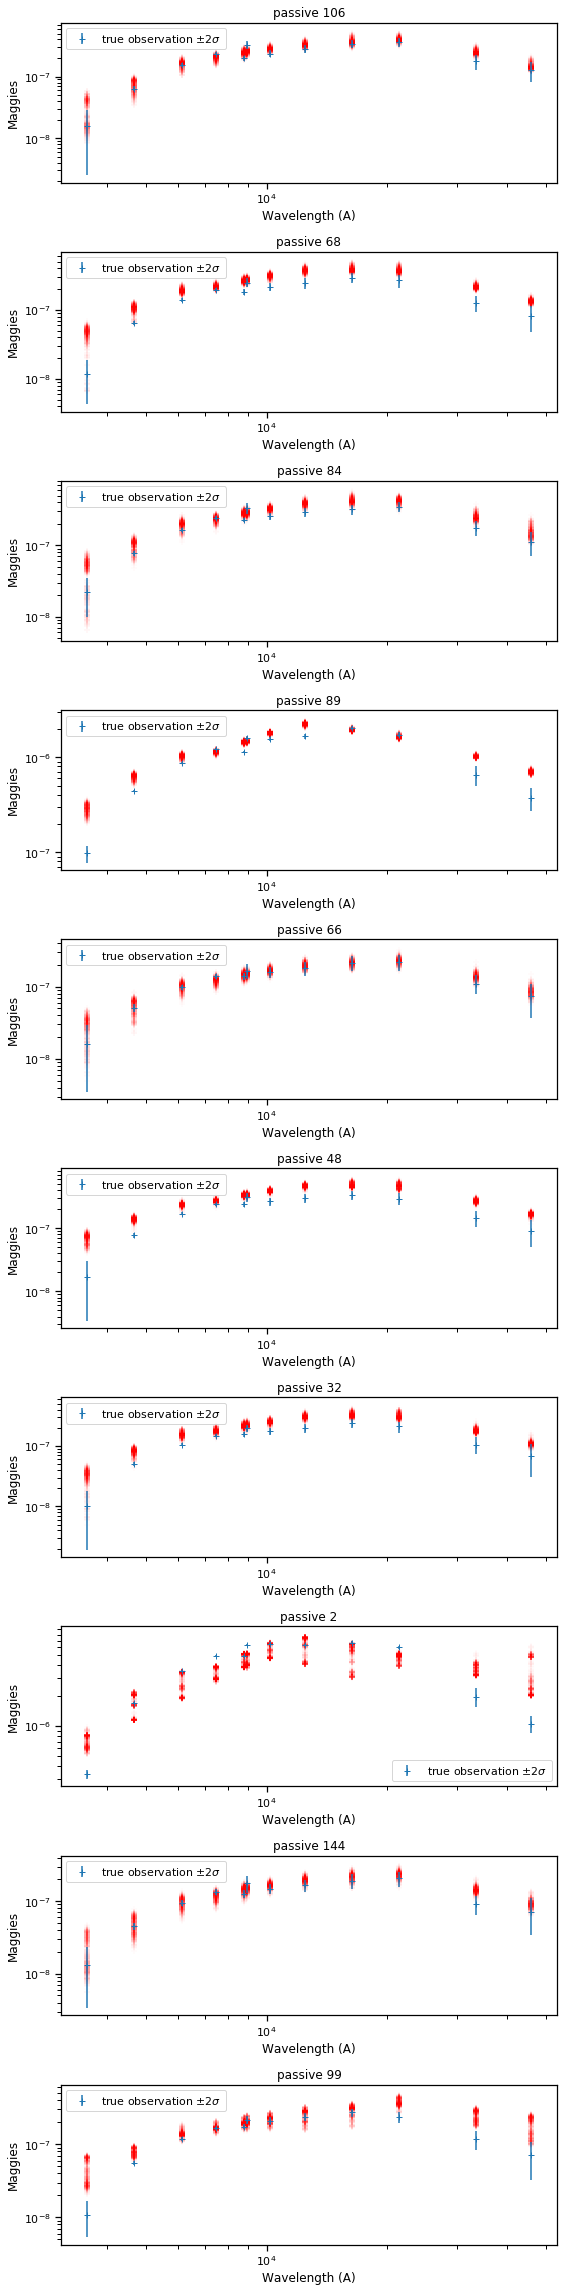

In [82]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

n = 0
for galaxy in galaxies:
    if galaxy['rf_class'] == 'passive':
        ax = axes[n]
        plot_galaxy(galaxy, ax, emulator, wavelengths)
        n += 1
    if n >= n_galaxies:
        break
plt.tight_layout()

In [63]:
galaxy['rf_class']

'qso'

In [64]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [65]:
raw_df.head()

,index,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,agn_inclination,rf_class
0,0,0.806896,0.059195,0.018430,0.652871,0.286637,0.978464,0.249907,0.804323,qso
1,1,0.778266,0.090606,0.009340,0.663266,0.315200,0.989667,0.237208,0.863707,qso
2,2,0.774266,0.051753,0.013350,0.697150,0.344982,0.960089,0.197345,0.813693,qso
3,3,0.802856,0.017428,0.021624,0.631217,0.307473,0.973060,0.184932,0.730849,qso
4,4,0.801620,0.052426,0.018603,0.608348,0.365293,0.943888,0.214673,0.700042,qso


In [66]:
len(raw_df)

92800

In [67]:
df = raw_df

In [68]:
df['rf_class']

0        qso
1        qso
2        qso
3        qso
4        qso
        ... 
92795    agn
92796    agn
92797    agn
92798    agn
92799    agn
Name: rf_class, Length: 92800, dtype: object

In [69]:
df[params].median()

mass                 0.692894
dust2                0.055704
tage                 0.361496
tau                  0.281152
agn_disk_scaling     0.541130
agn_eb_v             0.739994
agn_torus_scaling    0.284976
agn_inclination      0.477465
dtype: float32

In [70]:
(df[params] > 1e-3).shape

(92800, 8)

In [71]:
df = df[np.all(df[params] > 1e-3, axis=1)]
df = df[np.all(df[params] < .999, axis=1)]

In [72]:
df[params].min()

mass                 0.001174
dust2                0.001001
tage                 0.001001
tau                  0.001006
agn_disk_scaling     0.001005
agn_eb_v             0.001007
agn_torus_scaling    0.001000
agn_inclination      0.001014
dtype: float32

In [73]:
df[params].max()

mass                 0.998999
dust2                0.998975
tage                 0.998976
tau                  0.998999
agn_disk_scaling     0.998953
agn_eb_v             0.999000
agn_torus_scaling    0.998993
agn_inclination      0.998967
dtype: float32

In [74]:
# free_params = ['mass', 'dust2', 'tage', 'agn_eb_v', 'agn_torus_mass']
# log_params = ['mass', 'agn_mass', 'tau']

In [75]:
df['rf_class']

0        qso
1        qso
2        qso
3        qso
4        qso
        ... 
92795    agn
92796    agn
92797    agn
92798    agn
92799    agn
Name: rf_class, Length: 84399, dtype: object

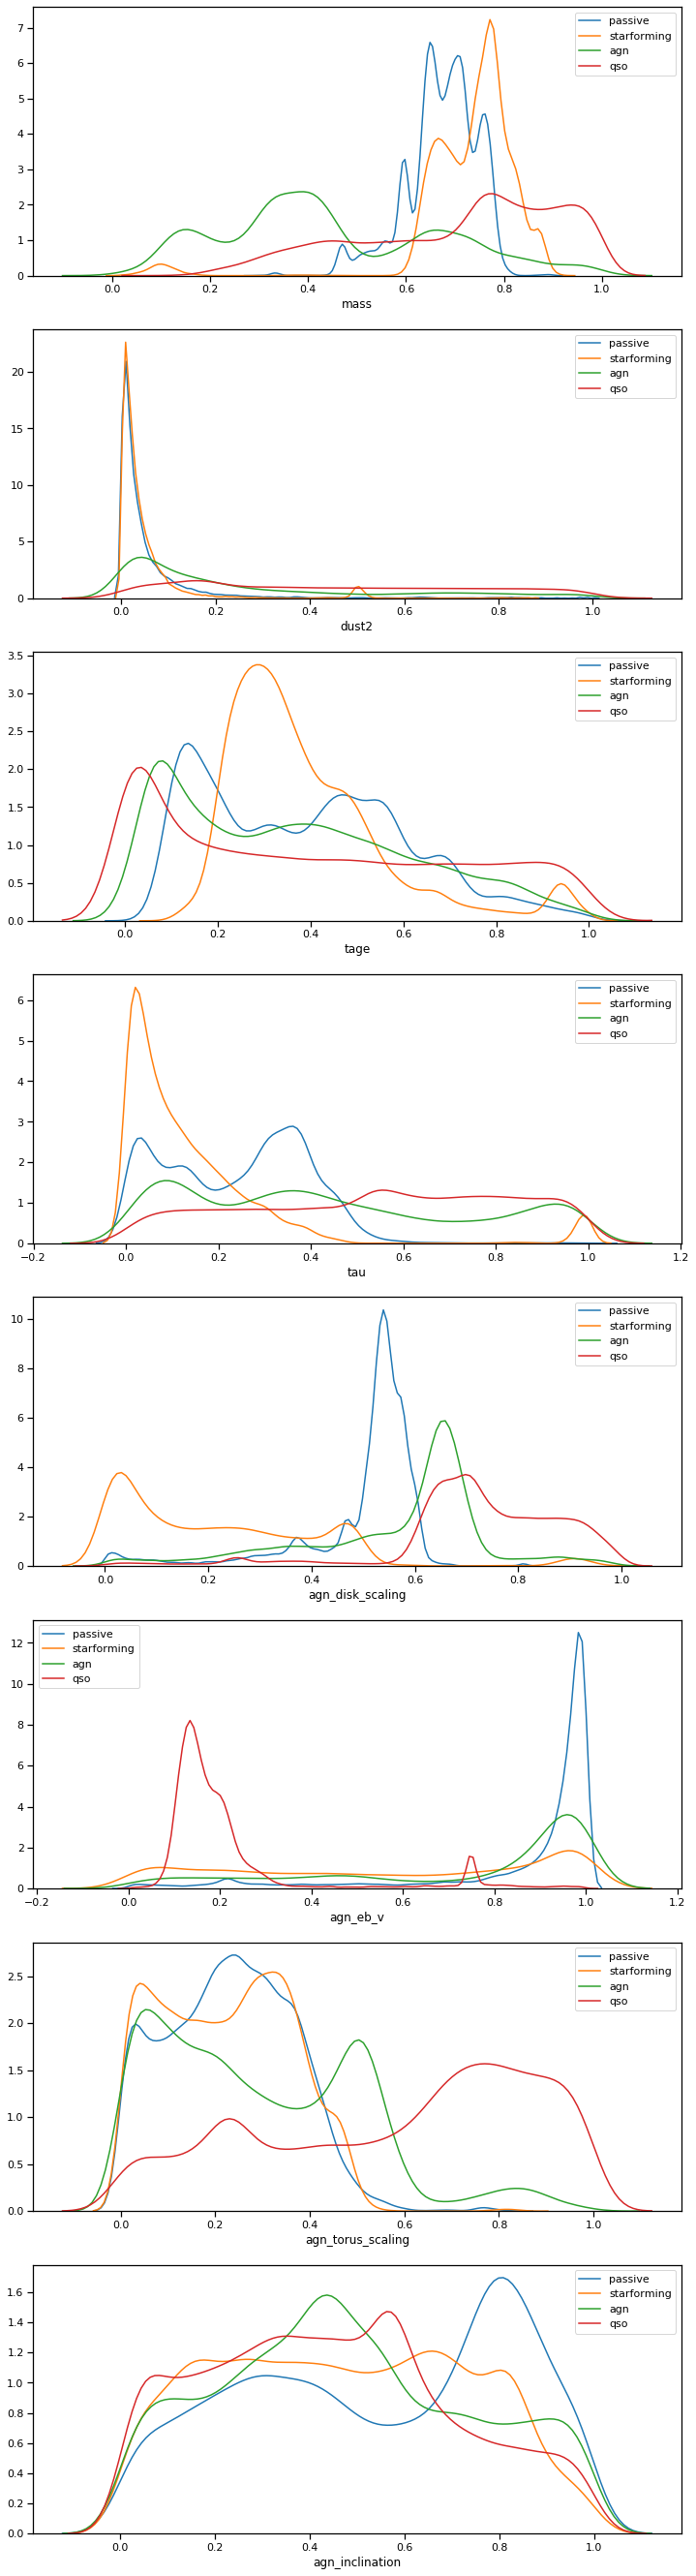

In [76]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in ['passive', 'starforming', 'agn', 'qso']:
        values = df[df['rf_class'] == galaxy_class][feature]
#         if feature in log_params:
#             values = np.log10(values)
#         print(values.shape)
        if len(values) > 0:
            sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

In [77]:
# df = df[df['rf_class'] != 'agn']

In [78]:
from agnfinder import simulation_utils
from collections import OrderedDict

# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())


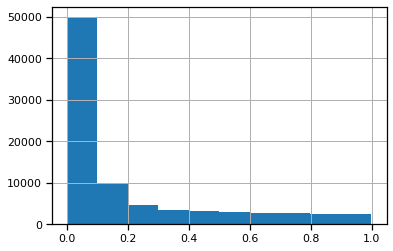

In [79]:
df['dust2'].hist()

In [80]:
for galaxy in galaxies:
    galaxy['denormalised_samples'] = simulation_utils.denormalise_theta(galaxy['samples'], free_params)

AssertionError: 

In [ ]:
galaxy['samples'][0]

In [ ]:
galaxy['denormalised_samples'][0]

In [ ]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['denormalised_samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [ ]:
df = raw_df

In [ ]:
df[params].min()

In [ ]:
log_params = ['mass', 'tau', 'agn_disk_scaling', 'agn_torus_scaling']

In [ ]:
df['dust2'].hist()

In [ ]:
df = df.query('mass > 10 ** -5')  # a few masses are broken

In [ ]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
#     for galaxy_class in rf_classes:
    for galaxy_class in ['passive', 'starforming', 'agn', 'qso']:
        values = df[df['rf_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        if len(values) > 0:
            try:
                sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
            except ValueError:
                print('Failed {} {}'.format(feature, galaxy_class))
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')